In [1]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 5.4 MB/s eta 0:00:00


In [2]:
!pip install advertools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.6 MB/s eta 0:00:00


In [3]:
pip install scikit-learn==1.5.2 imbalanced-learn==0.12.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
import string
from sklearn.utils import resample

import re
import contractions

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from wordcloud import WordCloud
import advertools as adv
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report,confusion_matrix

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [5]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

# Data Wrangling

In [6]:
df = train.copy()

In [7]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
df = df.fillna('')

In [10]:
pattern = 'live in'

df['text'][df['text'].str.contains(pattern,regex=True,flags=re.IGNORECASE)]

11      Haha South Tampa is getting flooded hah- WAIT ...
3497    #Tampa: Super Freestyle Explosion Live in Conc...
4869    Another White mass murderer. Thank God I live ...
7213    Lol\nLook how tough some people talk that live...
Name: text, dtype: object

In [11]:
df.iloc[7213,2] = 'Denver Colorado'
df.iloc[11,2 ]= 'South Tampa'
df.iloc[4869,2] = 'Califonia'

In [12]:
df[['location','text']][df[
'text'].str.contains('Hawaii',na=False, regex = True, flags=re.IGNORECASE)]

,location,text
3046,"Hawaii, USA",USGS reports a M1.94 #earthquake 5km S of Volc...
6275,,What tropical storm? #guillermo by hawaiianpad...
7129,ARGENTINA,#Earthquake #Sismo M 1.9 - 5km S of Volcano Ha...
7131,Earth,1.94 earthquake occurred 5km S of Volcano Hawa...
7132,,1.9 #Earthquake in 5Km S Of Volcano Hawaii #iP...
7135,"Hawaii, USA",USGS reports a M1.94 #earthquake 5km S of Volc...
7136,"Hawaii, USA",USGS EQ: M 1.9 - 5km S of Volcano Hawaii: Time...
7137,,#USGS M 1.9 - 5km S of Volcano Hawaii: Time201...
7140,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7151,,#Sismo M 1.9 - 5km S of Volcano Hawaii: Time20...


In [13]:
hawaii_index = train[['location']][train[
'text'].str.contains('Hawaii',na=False, regex = True, flags=re.IGNORECASE)].index.to_list()

for index_ in hawaii_index:
    df.iloc[index_,2] = 'Hawaii'

In [14]:
df[['location','text']][df[
'text'].str.contains('Canada',na=False, regex = True, flags=re.IGNORECASE)]

,location,text
1,,Forest fire near La Ronge Sask. Canada
990,#EngleWood CHICAGO,Idgaf who tough or who from Canada and who fro...
1138,,The cryptic words that guided pilots on the Hi...
2223,,The #Bible sometimes backs up the truck and un...
2595,Montreal,@freeMurphy Your hot take on Canada's hitchhik...
2819,Visit our dedicated website @,300000 Dead 1200000 injured 11000000 Displaced...
2859,"Okanagan Valley, BC",#MakeWaterWork Okanagan! Drought rating maxed ...
2863,Canada,CANADA BC DROUGHT: Okanagan region issued Leve...
4127,facebook.com/tradcatknights,Canada: Hailstorm flash flooding slam Calgary ...
5536,,I liked a @YouTube video http://t.co/V57NUgmGK...


In [15]:
mask = df['text'].str.contains('Canada', flags=re.IGNORECASE, regex=True, na=False)
df.loc[mask & (df['location'].isna() | (df['location'] == '')), 'location'] = 'Canada'

## 1. Common Hashtags used in Tweets

### Extract Hashtags

In [16]:
#EXTRACT HASHTAGS

def extract_hashtags(series):
    hashtag_summary = adv.extract_hashtags(series)
    hashtags = hashtag_summary['hashtags_flat'] #flaten hashtags to list
    tags = (" ").join(hashtags)

    return tags

In [17]:
tags = extract_hashtags(df['text'])

In [18]:
#from collections import Counter
#hashtag_dict = Counter(hashtags)

#dict(sorted(hashtag_dict.items(), key=lambda x: x[1], reverse=True)) #sort dictionary

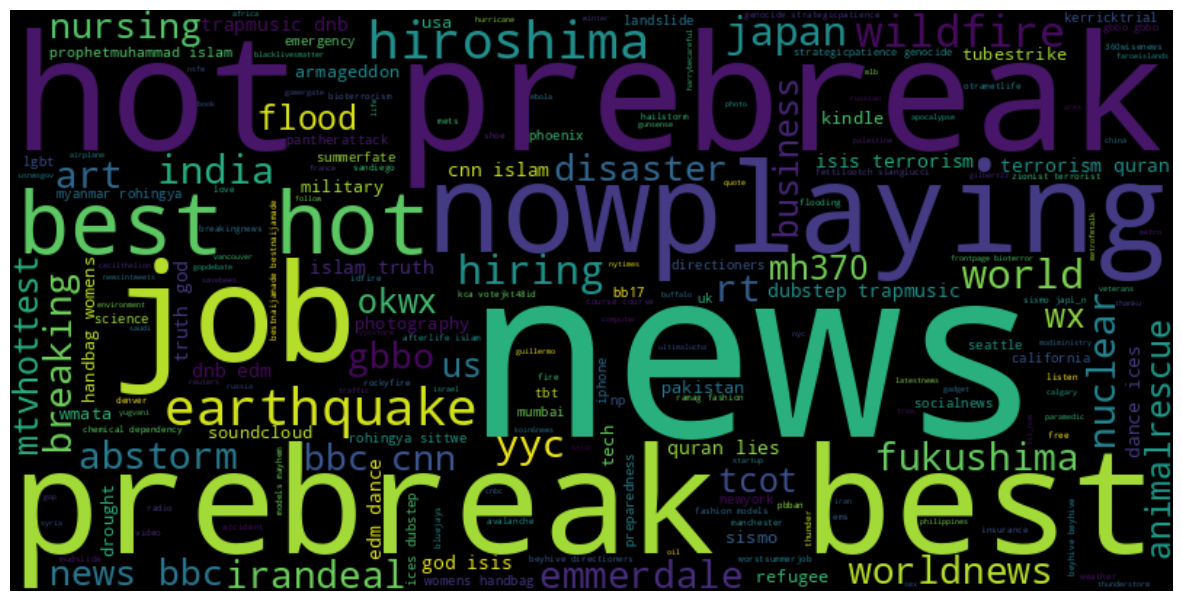

In [19]:
#CREATE WORDCLOUD

wordcloud = WordCloud(background_color='black', width=800, height=400).generate(tags)   

#display generated wordcloud
plt.figure(figsize=(15,12))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## 2.  Locations where most tweets originated from

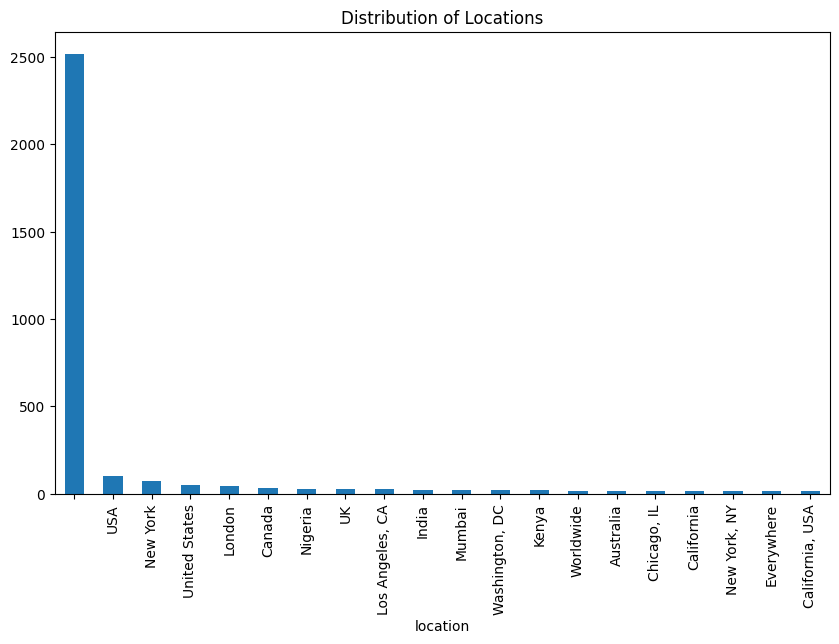

In [20]:
top_locations = df['location'].value_counts().nlargest(20) #i can also slice using [:20] or .iloc[:20
top_locations.plot.bar(figsize=(10,6))
plt.title('Distribution of Locations');

## 3. Common Keywords used in Tweets

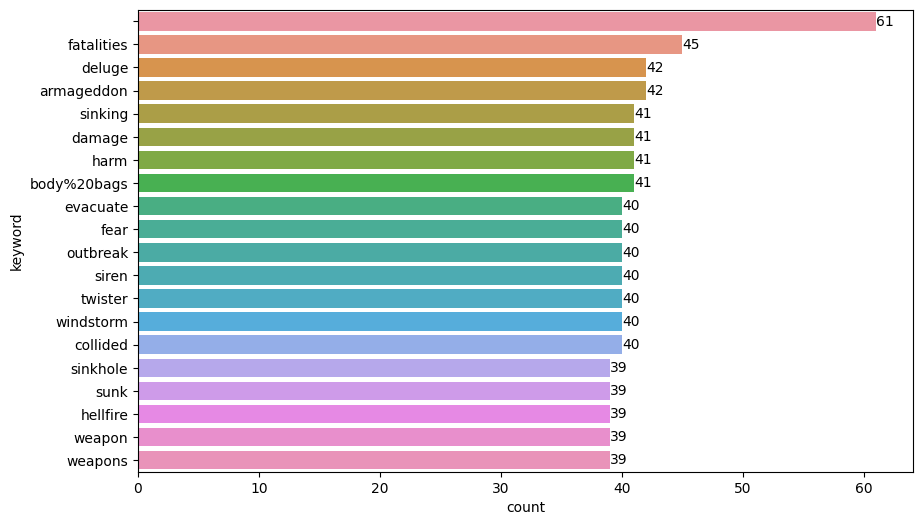

In [21]:
plt.figure(figsize=(10,6))
keyword_count = df['keyword'].value_counts().nlargest(20).reset_index()
ax = sb.barplot(data = keyword_count, x = 'count', y = 'keyword')#,width=0.9)
ax.bar_label(ax.containers[0], fontsize=10);

In [22]:
#EXTRACT MENTIONS

def extract_mentions(series):
    mentions_summary =  adv.extract_mentions(df['text'])
    mentions = mentions_summary['mentions_flat']
    all_mentions = (" ").join(mentions)

    return all_mentions

In [23]:
all_mentions = extract_mentions(df['text'])

In [24]:
# EXTRACT URL
def extract_urls(series):
    url_summary = adv.extract_urls(series)
    url_list = url_summary['urls_flat']
    all_urls = (" ").join(url_list)

    return all_urls

In [25]:
all_urls = extract_urls(df['text'])

# Feature Engineering

### Text Cleaning

Removing noise (i.e. unneccesary information) is a key part of getting the data into a usable format.  For this dataset, we will be carrying out the following cleaning techniques:

* removing the web urls

* removing duplicates

* removing usernames

* converting all text into lowercase

* removing punctuation marks

* removing stopwords from tweets

In [26]:
# REMOVE URLS

pattern = r'https?://[^\s,]+'

#REPLACE URL LINKS WITH 'WEB URL'

replace_url = r'web_url'
df['text'] = df['text'].replace(pattern,replace_url,regex=True)

There are 624 duplicate tweets. let's explore further

While each tweet has a unique id, some tweets are duplicated. from close observation, i npticed a couple of reasons:

1. some tweets were tweeted more than once...probably the user didnt know they have already sent the tweet already - network issues or stuff


i suspect retweets should be here too, but let's confirm

In [27]:
retweets = df[df['text'].str.contains('RT\s?\@',regex=True,flags=re.I)]

In [28]:
retweets[retweets.duplicated()]

,id,keyword,location,text,target


so no retweets were duplicated. let's go ahead and drop the duplicates and leave only one

In [29]:
#DROP DUPLICATES 

df.drop_duplicates(subset = 'text', keep = 'first',inplace = True) 

In [30]:
#CONVERT ALL TEXT TO LOWERCASE

df['text'] = df['text'].str.lower()

In [31]:
#REMOVE EXTRA WHITESPACE
df['text'] =df['text'].replace(r'\s\s+','',regex=True)

In [32]:
#REMOVE SPECIAL CHARACTERS

#pattern = r'[!"#$%&()*+,\-./:;<=>?@\[\\\]^_\'{|}~]'
#df['text'].replace(pattern,'',regex=True)

df['text'] = df['text'].apply(lambda x: ''.join(
    c for c in x if c not in string.punctuation))

* Escaped the square brackets: `\[ \]`

* Escaped the backslash: `\\`

* Escaped the dash (`-`) since inside `[]` it can define a range.

* Removed the stray spaces unless you intentionally want to remove them too.

In [33]:
#REMOVE NUMBERS
df['text'] = df['text'].str.replace('\d+', '', regex=True)

## The contractions library

In Python, the contractions module is used to expand English contractions — that is, to convert shortened forms of words into their full forms.

For example:

Contraction|	Expansion
---|----|
`"don't"`|	`"do not"`
`"can't"`|	`"cannot"`
`"it's"`	|`"it is"`
`"I'm"`	|`"I am"`
`"they've"`	|`"they have"`

This helps make your text cleaner and more consistent before applying NLP models, because models perform better when the text is standardized.

In [34]:
df['text'] = df['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])

df['text'] = df['text'].apply(lambda x: ' '.join(c for c in x))

let's create a function that will do this in the test dataset

In [35]:
def engineer_features(df):
    # REMOVE URLS
    pattern = r'https?://[^\s,]+'

    #REPLACE URL LINKS WITH 'WEB URL'
    replace_url = r'web_url'
    df['text'] = df['text'].replace(pattern,replace_url,regex=True)

    #DROP DUPLICATES 
    df.drop_duplicates(subset = 'text', keep = 'first',inplace = True) 
    
    #REMOVE EXTRA WHITESPACE
    df['text'] =df['text'].replace(r'\s\s+','',regex=True)

    #CONVERT ALL TEXT TO LOWERCASE
    df['text'] = df['text'].str.lower()

    #REMOVE SPECIAL CHARACTERS
    df['text'] = df['text'].apply(lambda x: ''.join(c for c in x if c not in string.punctuation))

    #APPLY CONTRACTIONS
    df['text'] = df['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])
    df['text'] = df['text'].apply(lambda x: ' '.join(c for c in x))

    return df

### DEALING WITH CLASS IMBALANCE IN THE TARGET COLUMN

In [36]:
#1 - DISASTER, 0 - NOT DISASTER
df['target'].value_counts()

target
0    4122
1    2867
Name: count, dtype: int64

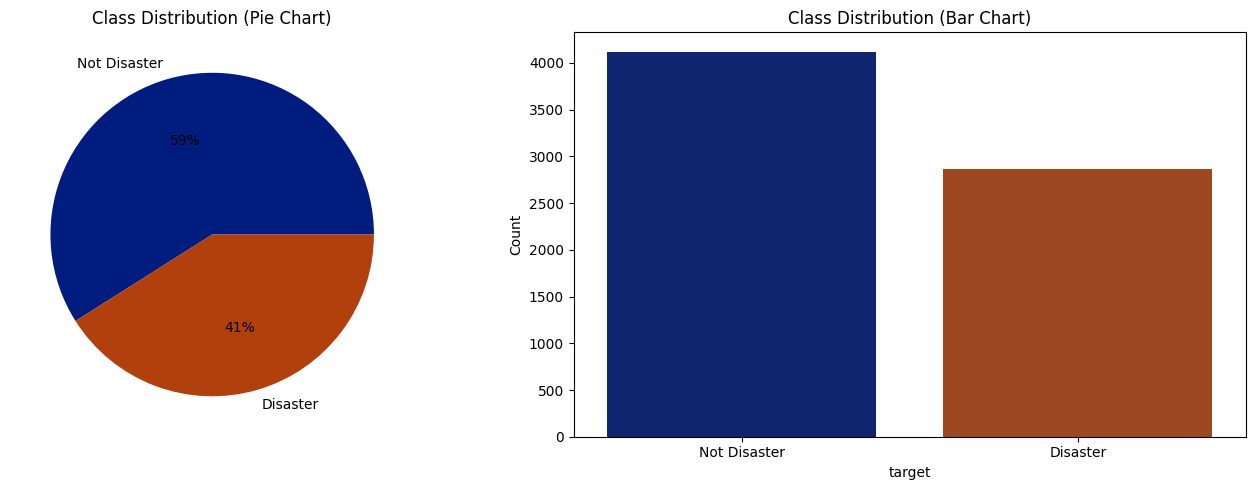

In [37]:
# Calculate class distribution
class_distribution = df['target'].value_counts()

# Create one figure with two plots side-by-side
plt.figure(figsize=(14, 5))

# --- Pie Chart ---
plt.subplot(1, 2, 1)
colors = sb.color_palette('dark')
plt.pie(class_distribution.values,
        labels=['Not Disaster', 'Disaster'],
        colors=colors,
        autopct='%.0f%%')
plt.title('Class Distribution (Pie Chart)')

# --- Bar Chart ---
plt.subplot(1, 2, 2)
sb.barplot(x=class_distribution.index,
           y=class_distribution.values,
           palette='dark')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'])
plt.title('Class Distribution (Bar Chart)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [38]:
df['target'].value_counts()

target
0    4122
1    2867
Name: count, dtype: int64

### ⚙️ What SMOTE Does

Unlike random upsampling (which duplicates existing samples),
SMOTE creates new, synthetic samples for the minority class by interpolating between existing ones.

In simpler terms:

> It looks at the minority samples that already exist, picks two that are close together, and generates a new, similar one in between.

This makes the data more varied and helps your model generalize better.

### Tokenization 

Tokenization is a fundamental step in Natural Language Processing (NLP). It involves dividing a Textual input into smaller units known as tokens. 

In [39]:
tokeniser = TreebankWordTokenizer()
df['tokens'] = df['text'].apply(tokeniser.tokenize)

### Stop Words

Stop words are words which do not contain important significance to be used in Search Queries. Usually these words are filtered out from search queries because they return a vast amount of unnecessary information. `nltk` has a corpus of stopwords. Let's print out the stopwords for English.

### 🔹 When You Should Remove Them

#### ✅ Useful for tasks like:

- Text classification (e.g., disaster tweet detection)

- Topic modeling

- Information retrieval

#### ❌ Sometimes keep them for:

- Sentiment analysis (e.g., “not good” → removing “not” changes meaning)

- Language modeling (if you’re training an LLM or text generator)

**So — don’t always remove stop words blindly. It depends on your task.**

# Modelling

In [40]:
#VECTORISE FEATURES

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text'])
y = df['target']

In [41]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27, stratify=y)

In [42]:
# Apply SMOTE
smote = SMOTE(random_state=27)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())

Before SMOTE: target
0    3297
1    2294
Name: count, dtype: int64
After SMOTE: target
1    3297
0    3297
Name: count, dtype: int64


### WITH SKLEARN

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [44]:
lr =  LogisticRegression()
lr.fit(X_train_smote,y_train_smote)

lr_model = lr.predict(X_test)

In [45]:
rf = RandomForestClassifier()
rf.fit(X_train_smote, y_train_smote)

rf_model = rf.predict(X_test)

In [46]:
xg = XGBClassifier()
xg.fit(X_train_smote,y_train_smote)

xg_model = xg.predict(X_test)

In [47]:
print(classification_report(lr_model,y_test))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       923
           1       0.66      0.79      0.72       475

    accuracy                           0.79      1398
   macro avg       0.77      0.79      0.78      1398
weighted avg       0.81      0.79      0.79      1398



our `lr_model` performed the best

# NOTES

1. https://advertools.readthedocs.io/en/master/advertools.kw_generate.html
2. https://seaborn.pydata.org/generated/seaborn.barplot.html
3. https://github.com/eliasdabbas/advertools?tab=readme-ov-file
4. https://www.geeksforgeeks.org/nlp/nlp-how-tokenizing-text-sentence-words-works/
5. https://www.pythontutorial.net/python-regex/python-regex-quantifiers/
6. https://python-tutorials.in/regular-expression-quantifiers/
7. https://mljourney.com/tf-idf-vectorizer-vs-countvectorizer-the-key-differences-for-text-analysis/